## IMPORTS

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import plotly.express as px

In [4]:
from sklearn.model_selection import cross_val_score, KFold, train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeRegressor
from sklearn import datasets
from sklearn.metrics import mean_squared_error, r2_score

import scipy
import scipy.stats as stats
import statsmodels.api as sm

# MODELLING - WITHOUT STANDARDISATION AND WITHOUT REMOVING OUTLIERS

- Outliers have been left in
- Standardisation not applied
- Feature count: 4661
- Sparse Matrix Applied

In [5]:
modelling_dataset = "./data/bromley_croydon_clean/brom_croy_2021_2022_freehold_5_bed_cutoff.csv"

In [13]:
df = pd.read_csv(modelling_dataset) 

In [7]:
#geocode_df = pd.read_csv('./data/bromley_croydon_clean/brom_croy_2021_2022_freehold_geocode_full.csv')

In [8]:
#geocode_dataset[geocode_dataset.result == 0].index

In [9]:
#[59, 807, 1796, 2846, 4055, 4539, 6224]

In [14]:
#textual = ['postcode', 'postcode_half1', 'property_type']
numerical = ['bedrooms','bathrooms','lounges']
pred = ['last_sold_price_gbp']



#### Dummification

Minimal Features - Just bedrooms bathrooms and lounges

In [15]:
dum_df = pd.concat([pd.get_dummies(df[numerical])], axis=1)

In [16]:
dum_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7903 entries, 0 to 7902
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   bedrooms   7903 non-null   float64
 1   bathrooms  7903 non-null   float64
 2   lounges    7903 non-null   int64  
dtypes: float64(2), int64(1)
memory usage: 185.4 KB


In [17]:
sparse_df = scipy.sparse.csr_matrix(dum_df.values)

In [34]:
#X = dum_df
#y = df[pred]
y = np.log10(df[pred])

#Sparse Version
X = sparse_df


#### Train Test Split

In [35]:
train_test_tuple = X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,shuffle=True)

In [36]:
kf = 5 # KFold(n_splits=5, shuffle=True, random_state=10)

#### Standardisation

In [37]:
# sc = StandardScaler()
# X_train = sc.fit_transform(X_train)
# X_test = sc.transform(X_test)

In [38]:
#X_train = scipy.sparse.csr_matrix(X_train)
#X_test = scipy.sparse.csr_matrix(X_test)

#### Creating a Model Scoring Function

In [39]:
def model_scorer(model, X_tr, X_ts, y_tr, y_ts):
    """Convenience function to print model scores and return """
    train_score = model.score(X_tr, y_tr)
    print('Train score:', train_score)
    
    cv = cross_val_score(model, X_tr, y_tr, cv=kf)
    print('CV scores:', cv)
    print('CV standard deviation:', cv.std() )
    print('Mean CV score:', cv.mean())
    
    test_score = model.score(X_ts, y_ts)
    print('Test score:', model.score(X_ts, y_ts))
     
    return {"train_score":train_score,
            "cv_scores":cv,
            "test_score":test_score}

#### Linear Regression - Good Score

In [40]:
lin_model_1 = LinearRegression()
lin_model_1.fit(X_train, y_train)


LinearRegression()

In [41]:
model_scorer(lin_model_1, X_train, X_test, y_train, y_test);

Train score: 0.3596228604758258
CV scores: [0.34179357 0.34721746 0.38026469 0.34462907 0.38087901]
CV standard deviation: 0.017732916982732914
Mean CV score: 0.3589567581925656
Test score: 0.3411022207267468


#### Decision Tree - Good Score

In [42]:
dt_model_1 = DecisionTreeRegressor()
dt_model_1.fit(X_train, y_train)

DecisionTreeRegressor()

In [204]:
model_scorer(dt_model_1, *train_test_tuple);

Train score: 0.5096969656388473
CV scores: [0.51526451 0.40624587 0.5253415  0.46919159 0.43739607]
CV standard deviation: 0.045249198565527775
Mean CV score: 0.47068791002174015
Test score: 0.5009746653343444


#### Random Forest - Best Mean CV Score

In [205]:
rf_model_1 = RandomForestRegressor()
rf_model_1.fit(X_train, y_train.values.flatten())

RandomForestRegressor()

In [206]:
rf_model_1.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'mse',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

In [207]:
model_scorer(rf_model_1, X_train, X_test, y_train.values.flatten(), y_test.values.flatten());

Train score: 0.5085532609037084
CV scores: [0.51930986 0.41171138 0.52496049 0.48371805 0.44387103]
CV standard deviation: 0.04357795122872237
Mean CV score: 0.4767141628857602
Test score: 0.5015461987327532


##### GridSearching Random Forest

In [102]:
params = {'n_estimators': [100, 500, 700, 1000],
          'max_depth': [None, 1, 2, 3],
          'min_samples_split': [2, 3, 4]
         } 

gs = GridSearchCV( 
             RandomForestRegressor(),
             param_grid=params,
             n_jobs=2,
             cv = 3,
             verbose=2
            )


In [104]:
gs.fit(X_train, y_train.values.flatten())

Fitting 3 folds for each of 48 candidates, totalling 144 fits


/Users/oscarmumford/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/oscarmumford/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/oscarmumford/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/Users/oscarmumford/opt/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 1043, in __call__
    if self.dispatch_one_batch(iterator):
  File "/Users/oscarmumford/opt/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 861, in dispatch_one_batch
    self._dispatch(tasks)
  File "/Users/oscarmumford/opt/anaconda3/lib/python3.9

GridSearchCV(cv=3, estimator=RandomForestRegressor(), n_jobs=2,
             param_grid={'max_depth': [None, 1, 2, 3],
                         'min_samples_split': [1, 2, 3],
                         'n_estimators': [100, 500, 700, 1000]},
             verbose=2)

[CV] END max_depth=None, min_samples_split=1, n_estimators=100; total time=   0.1s
[CV] END max_depth=None, min_samples_split=1, n_estimators=100; total time=   0.1s
[CV] END max_depth=None, min_samples_split=1, n_estimators=500; total time=   0.4s
[CV] END max_depth=None, min_samples_split=1, n_estimators=700; total time=   0.5s
[CV] END max_depth=None, min_samples_split=1, n_estimators=700; total time=   0.5s
[CV] END max_depth=None, min_samples_split=1, n_estimators=1000; total time=   0.9s
[CV] END max_depth=None, min_samples_split=2, n_estimators=100; total time=   1.0s
[CV] END max_depth=None, min_samples_split=2, n_estimators=100; total time=   1.0s
[CV] END max_depth=None, min_samples_split=2, n_estimators=500; total time=   4.7s
[CV] END max_depth=None, min_samples_split=2, n_estimators=700; total time=   6.3s
[CV] END max_depth=None, min_samples_split=2, n_estimators=700; total time=   6.0s
[CV] END max_depth=None, min_samples_split=2, n_estimators=1000; total time=   8.2s
[C

In [114]:
model_scorer(gs.best_estimator_, X_train, X_test, y_train.values.flatten(), y_test.values.flatten())

Train score: 0.5477125518182102
CV scores: [0.48615587 0.38175505 0.50381432 0.53096542 0.3951093 ]
CV standard deviation: 0.0599533510141968
Mean CV score: 0.45955999186007696
Test score: 0.3717558945818148


{'train_score': 0.5477125518182102,
 'cv_scores': array([0.48615587, 0.38175505, 0.50381432, 0.53096542, 0.3951093 ]),
 'test_score': 0.3717558945818148}

### Modellling with Regularisation

In [25]:
from sklearn.linear_model import RidgeCV, LassoCV, ElasticNetCV, Ridge, Lasso, ElasticNet

#### Ridge

We close in on the best alpha by testing a wide range of alphas and then choosing the best range and then looking at it with ever more granularity. Here this is seen by iterating RidgeCV multiple times

In [122]:
ridge_cv_1 = RidgeCV(alphas=np.logspace(-10,10,11))
ridge_cv_1.fit(X_train,y_train)

RidgeCV(alphas=array([1.e-10, 1.e-08, 1.e-06, 1.e-04, 1.e-02, 1.e+00, 1.e+02, 1.e+04,
       1.e+06, 1.e+08, 1.e+10]))

In [123]:
ridge_cv_1.alpha_

1.0

In [124]:
ridge_cv_2 = RidgeCV(alphas=np.logspace(-2,2,11))
ridge_cv_2.fit(X_train,y_train)

RidgeCV(alphas=array([1.00000000e-02, 2.51188643e-02, 6.30957344e-02, 1.58489319e-01,
       3.98107171e-01, 1.00000000e+00, 2.51188643e+00, 6.30957344e+00,
       1.58489319e+01, 3.98107171e+01, 1.00000000e+02]))

In [125]:
ridge_cv_2.alpha_

39.810717055349734

In [126]:
ridge_cv_3 = RidgeCV(alphas=np.linspace(1.58489319e-01,1.00000000e+00, 21))
ridge_cv_3.fit(X_train,y_train)

RidgeCV(alphas=array([0.15848932, 0.20056485, 0.24264039, 0.28471592, 0.32679146,
       0.36886699, 0.41094252, 0.45301806, 0.49509359, 0.53716913,
       0.57924466, 0.62132019, 0.66339573, 0.70547126, 0.7475468 ,
       0.78962233, 0.83169786, 0.8737734 , 0.91584893, 0.95792447,
       1.        ]))

In [127]:
ridge_cv_3.alpha_

1.0

In [128]:
ridge_cv_4 = RidgeCV(alphas=np.linspace(0.36886699,0.41094252, 21))
ridge_cv_4.fit(X_train,y_train)

RidgeCV(alphas=array([0.36886699, 0.37097077, 0.37307454, 0.37517832, 0.3772821 ,
       0.37938587, 0.38148965, 0.38359343, 0.3856972 , 0.38780098,
       0.38990475, 0.39200853, 0.39411231, 0.39621608, 0.39831986,
       0.40042364, 0.40252741, 0.40463119, 0.40673497, 0.40883874,
       0.41094252]))

In [129]:
ridge_cv_4.alpha_

0.41094252

In [130]:
ridge_alpha_1 = ridge_cv_1.alpha_
ridge_model_1 = Ridge(alpha=ridge_alpha_1)
ridge_model_1.fit(X_train, y_train)

Ridge()

In [131]:
model_scorer(ridge_model_1, *train_test_tuple);

Train score: 0.3817610864400821
CV scores: [0.36634217 0.41158904 0.33433747 0.43645723 0.33711221]
CV standard deviation: 0.04063530305061718
Mean CV score: 0.37716762553983285
Test score: 0.3988206993553367


In [132]:
ridge_model_1.alpha

1.0

In [133]:
ridge_alpha_2 = ridge_cv_2.alpha_
ridge_model_2 = Ridge(alpha=ridge_alpha_2)
ridge_model_2.fit(X_train, y_train)

Ridge(alpha=39.810717055349734)

In [134]:
model_scorer(ridge_model_2, *train_test_tuple);

Train score: 0.3817516497239467
CV scores: [0.36658485 0.41127492 0.33473101 0.43581174 0.3375611 ]
CV standard deviation: 0.040209389462683764
Mean CV score: 0.3771927228456758
Test score: 0.3985255102170351


In [135]:
ridge_model_2.alpha

39.810717055349734

In [136]:
ridge_alpha_3 = ridge_cv_3.alpha_
ridge_model_3 = Ridge(alpha=ridge_alpha_3)
ridge_model_3.fit(X_train, y_train)

Ridge()

In [137]:
model_scorer(ridge_model_3, *train_test_tuple);

Train score: 0.3817610864400821
CV scores: [0.36634217 0.41158904 0.33433747 0.43645723 0.33711221]
CV standard deviation: 0.04063530305061718
Mean CV score: 0.37716762553983285
Test score: 0.3988206993553367


#### Lasso - Good Score

In [138]:
lasso_cv_1 = LassoCV()
lasso_cv_1.fit(X_train, y_train.values.flatten())


LassoCV()

In [139]:
lasso_alpha = lasso_cv_1.alpha_
lasso_model_1 = Lasso(alpha=lasso_alpha)
lasso_model_1.fit(X_train, y_train.values.flatten())

Lasso(alpha=159.0830161631408)

In [140]:
model_scorer(lasso_model_1, X_train, X_test, y_train.values.flatten(), y_test.values.flatten());

Train score: 0.38176035331088876
CV scores: [0.36639117 0.41153263 0.33441513 0.43629581 0.33720696]
CV standard deviation: 0.04054098980135216
Mean CV score: 0.3771683407592624
Test score: 0.39872217088748185


#### ElasticNet

In [ ]:
alpha_range = np.logspace(-10,10,21)
l1_range = [.1, .5, .7, .9, .95, .99, 1]

elasticnet_cv_1 = ElasticNetCV(l1_ratio= l1_range,
                               alphas=alpha_range,
                               cv=3,
                               random_state=1,
                               n_jobs=2,
                               max_iter=10000
                              )
elasticnet_cv_1.fit(X_train,y_train.values.flatten())

In [ ]:
elasticnet_cv_1.l1_ratio_

In [ ]:
elasticnet_cv_1.alpha_

In [ ]:
elasticnet_alpha = elasticnet_cv_1.alpha_
elasticnet_l1 = elasticnet_cv_1.l1_ratio_
elasticnet_model_1 = ElasticNet(alpha=elasticnet_alpha, l1_ratio=elasticnet_l1)
elasticnet_model_1.fit(X_train, y_train.values.flatten())


In [ ]:
model_scorer(elasticnet_model_1, X_train, X_test, y_train.values.flatten(), y_test.values.flatten());

### BOOSTING

In [51]:
from sklearn.ensemble import AdaBoostRegressor, BaggingRegressor, GradientBoostingRegressor

#### AdaBoost

In [52]:
base_estimator = DecisionTreeRegressor()
ada_model_1 = AdaBoostRegressor(base_estimator=base_estimator,
                          n_estimators=100,
                          random_state=1)
ada_model_1.fit(X_train, y_train.values.flatten())


AdaBoostRegressor(base_estimator=DecisionTreeRegressor(), n_estimators=100,
                  random_state=1)

In [53]:
model_scorer(ada_model_1, X_train, X_test, y_train.values.flatten(), y_test.values.flatten());

Train score: 0.990808945118217
CV scores: [0.60227246 0.48239121 0.58253535 0.53850878 0.77246815]
CV standard deviation: 0.09754299583445931
Mean CV score: 0.595635189296827
Test score: 0.789133450773172


#### Gradient Boost

In [54]:
gradientBoost_model_1 = GradientBoostingRegressor(
    n_estimators=100,
    max_depth=3,
    learning_rate=0.1,
    random_state=1)

gradientBoost_model_1.fit(X_train, y_train.values.flatten())


GradientBoostingRegressor(random_state=1)

In [55]:
model_scorer(gradientBoost_model_1, X_train, X_test, y_train.values.flatten(), y_test.values.flatten());

Train score: 0.8061598107384746
CV scores: [0.71926422 0.63115217 0.56896528 0.56968125 0.72771892]
CV standard deviation: 0.0692676559330288
Mean CV score: 0.6433563683091353
Test score: 0.7649969284157461


{'train_score': 0.8061598107384746,
 'cv_scores': array([0.71926422, 0.63115217, 0.56896528, 0.56968125, 0.72771892]),
 'test_score': 0.7649969284157461}

# SCIPY MODELLING?

Statsmodels do not work with sparse matrices so I will not be implementing this for the fully dummified postcode model

# COEFFICIENT ANALYSIS

In [141]:
# collect the model coefficients in a dataframe
lin_model_1_coefs = pd.DataFrame(lin_model_1.coef_.flatten(), index=dum_df.columns,
                       columns=['coefficients'])
# calculate the absolute values of the coefficients
lin_model_1_coefs['coef_abs'] = lin_model_1_coefs.coefficients.abs()
#lin_model_1_coefs.sort_values('coef_abs', ascending=False).head(20)

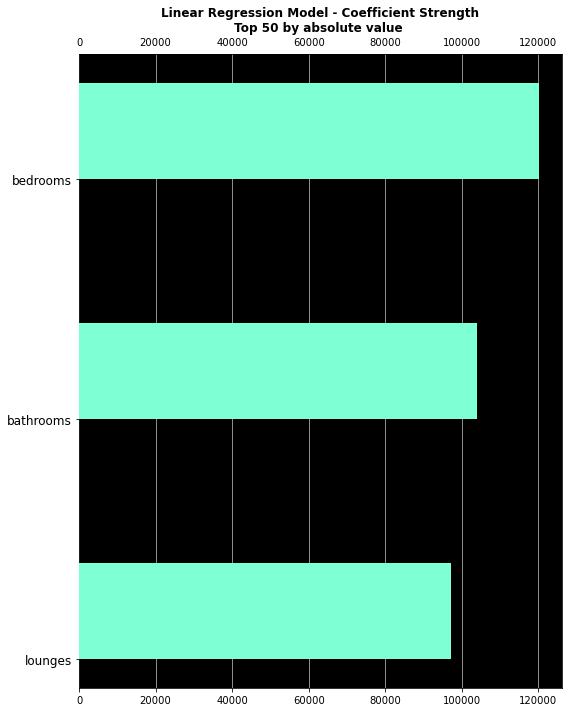

In [142]:
# plot the magnitude of the coefficients
fig, ax = plt.subplots(figsize=(8,10))
n_values_to_display = 50
plt_x = lin_model_1_coefs['coef_abs'].sort_values( ascending=False)[:n_values_to_display][::-1]
plt_y = lin_model_1_coefs[['coef_abs']].sort_values('coef_abs', ascending=False)[:n_values_to_display].index[::-1]

ax.barh(y=plt_y, width=plt_x, height=0.4, color='aquamarine', align='edge', zorder=3)
plt.yticks(fontsize=12) #fontdict={"fontsize":10})
#lin_model_1_coefs['coef_abs'].sort_values(ascending=False)[:20].plot(kind='barh', figsize=(10,20), color='purple')
ax.set_title(f"Linear Regression Model - Coefficient Strength\nTop {n_values_to_display} by absolute value ", fontweight='bold')#fontdict={'fontweight':"b"})

ax.set_facecolor('black')
ax.grid(axis='x', zorder=0)
ax.tick_params(labeltop=True)
plt.tight_layout();

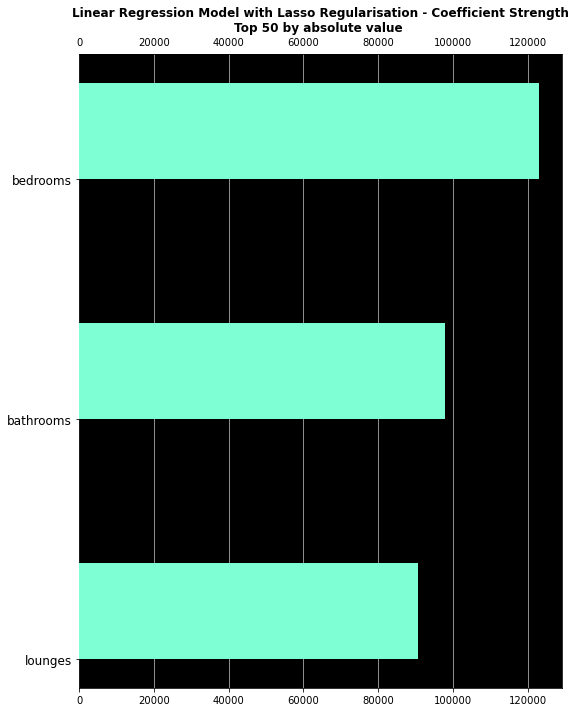

In [143]:
# collect the model coefficients in a dataframe
lasso_model_1_coefs = pd.DataFrame(lasso_model_1.coef_.flatten(), index=dum_df.columns,
                       columns=['coefficients'])
# calculate the absolute values of the coefficients
lasso_model_1_coefs['coef_abs'] = lasso_model_1_coefs.coefficients.abs()
#lasso_model_1_coefs.sort_values('coef_abs', ascending=False).head(20)


# plot the magnitude of the coefficients
fig, ax = plt.subplots(figsize=(8,10))
n_values_to_display = 50
plt_x = lasso_model_1_coefs['coef_abs'].sort_values( ascending=False)[:n_values_to_display][::-1]
plt_y = lasso_model_1_coefs[['coef_abs']].sort_values('coef_abs', ascending=False)[:n_values_to_display].index[::-1]

ax.barh(y=plt_y, width=plt_x, height=0.4, color='aquamarine', align='edge', zorder=3)
plt.yticks(fontsize=12) #fontdict={"fontsize":10})
#lasso_model_1_coefs['coef_abs'].sort_values(ascending=False)[:20].plot(kind='barh', figsize=(10,20), color='purple')
ax.set_title(f"Linear Regression Model with Lasso Regularisation - Coefficient Strength\nTop {n_values_to_display} by absolute value ", fontweight='bold')#fontdict={'fontweight':"b"})

ax.set_facecolor('black')
ax.grid(axis='x', zorder=0)
ax.tick_params(labeltop=True)
plt.tight_layout();

# RESIDUAL ANALYSIS

(1722,)

In [157]:
residuals = y_test.values.flatten() - lin_model_1.predict(X_test).flatten()

array([ 120024.57412782,  121174.57119397,  -17086.75348508, ...,
         89019.57412782,  -95975.42587218, -120905.88936238])

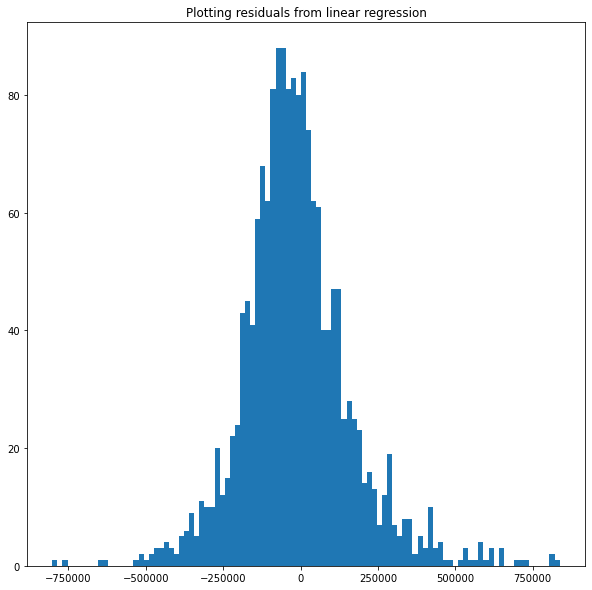

In [170]:
fig, ax = plt.subplots(figsize=(10,10))
ax.hist(residuals[residuals < 10 ** 6], bins=100)
ax.set_title("Plotting residuals from linear regression");



### Visually testing predictions


In [175]:
y_test.iloc[25]

last_sold_price_gbp    532500.0
Name: 70352, dtype: float64

In [176]:
lin_model_1.predict(X_test[25])

array([[573118.31715066]])

In [177]:
rf_model_1.predict(X_test[25])

array([548880.])

In [178]:
dt_model_1.predict(X_test[25])

array([575000.])

# CONCLUSIONS


The best score achieved was using the Random Forest Regressor model with an R2 score of 0.7605. This means we have captured 76% of the predictive power with regards to true value of properties in the given areas of London using our best model. 

That said across models, the mean cv scores were significantly lower than the test scores and often had a wider spread. This may speak to a number of issues in the model. 
- The dataset may not be large enough to support the folds used (5)


The coefficients which had the largest affect on our score after Lasso Regularization were:
- Bedrooms
- Bathrooms
- Certain individual postcodes

One issue with the model may be the large number of dummified postcodes. As our dataset is relatively small individual postcodes have fewer and fewer unique properties. This means our full-postcode feature is acting almost like a uid value. That being said the test scores do indicate that we are not overfitting the model and that bias is kept relatively low


Additional issues with the model are indicated by the residual plots:
It is most likely that we are missing a great deal of additional independent variables in assessing the value of a property, the most obvious being square footage which can vary greatly between properties of similar number of rooms.

# NEXT STEPS - IMPROVING THE MODEL AND BEYOND


Our model would ideally be improved in a number of ways. 

Next goals of the model are to scrape all available properties in London (circa 3.5 Million). This will hopefully yield a much more general model of London property prices and allow the ultimate goal of the project which is to use the historical price model to predict whether particular properties listed on Zoopla are undervalued or not thereby identifying investment opportunities.